In [6]:
!pip install rebound
!pip install reboundx
import scipy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import rebound
import reboundx
import warnings
warnings.filterwarnings("ignore")
random.seed(2018)
np.random.seed(seed=2018) 

In [8]:
# Simple solar system example

sim = rebound.Simulation()  ## Initiate simulation
sim.units = ('yr', 'AU', 'Msun')  ##Choose units
sim.add("Sun")  ## Add object from online database
sim.add("Jupiter")  ## Add Jupiter
sim.add(m=9.4716e-5,a=9.58,    e=0.0565 )  ## add planets manually: Saturn
sim.add(m=4.3645e-5,a=19.2184, e=0.04638 )  ## add planets manually: Uranus
sim.add(m=5.1483e-5,a=30.11,   e=0.009456 )  ## Neptune
sim.add(m=0,a=40.0,  e=0.5 )  ## comet
sim.add(m=0,a=35.0,  e=0.6 )  ## Another comet
sim.add(m=0,a=30.0,  e=0.7 )  ## Another comet


#  Print orbital parameters pre-integration
for orbit in sim.calculate_orbits():
    print(orbit)
    
fig = rebound.OrbitPlot(sim, trails=True, unitlabel="[AU]")

    
sim.integrator = "whfast"
sim.dt = 11.86/10. # integration timestep, smallest period / 10
tmax = 1e4    # tmax is the total duration of the integration
sim.integrate(tmax)  # Do the integration


print ('------------------------------------------------------------')     
print ('------------------------------------------------------------')     
print ('------------------------------------------------------------')     

#  Print orbital parameters post-integration
for orbit in sim.calculate_orbits():
    print(orbit)
fig = rebound.OrbitPlot(sim, trails=True, unitlabel="[AU]")

    


Searching NASA Horizons for 'Sun'... Found: Sun (10).
Searching NASA Horizons for 'Jupiter'... Found: Jupiter Barycenter (5).
<rebound.Orbit instance, a=5.202547807226863 e=0.048836977504962756 inc=0.022753651658835285 Omega=1.7543332112170138 omega=-1.5068640561487658 f=3.9894983614370894>
<rebound.Orbit instance, a=9.58 e=0.0565 inc=0.0 Omega=0.0 omega=0.0 f=0.0>
<rebound.Orbit instance, a=19.2184 e=0.046380000000000095 inc=0.0 Omega=0.0 omega=0.0 f=0.0>
<rebound.Orbit instance, a=30.109999999999996 e=0.009455999999999725 inc=0.0 Omega=0.0 omega=0.0 f=0.0>
<rebound.Orbit instance, a=40.00000000000001 e=0.5000000000000001 inc=0.0 Omega=0.0 omega=0.0 f=0.0>
<rebound.Orbit instance, a=35.00000000000003 e=0.6000000000000003 inc=0.0 Omega=0.0 omega=0.0 f=0.0>
<rebound.Orbit instance, a=29.999999999999975 e=0.6999999999999997 inc=0.0 Omega=0.0 omega=0.0 f=0.0>
------------------------------------------------------------
------------------------------------------------------------
---------

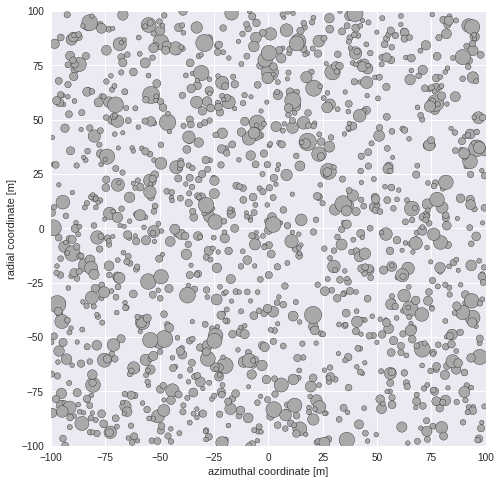

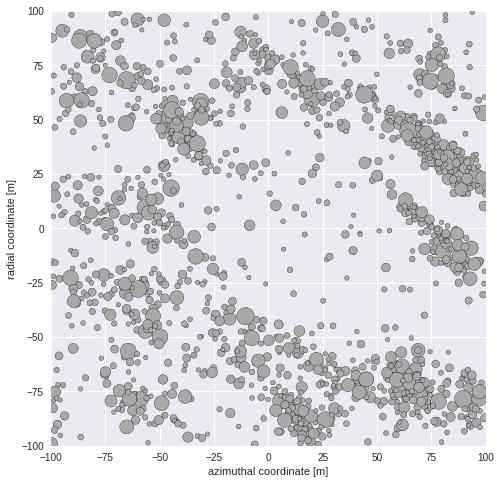

In [9]:

# coding: utf-8

# # Simulating Saturn's rings
# 
# In this example, we will simulate a small patch of Saturn's rings. The simulation is similar to the C example in `examples/shearing_sheet`.
# 
# We first import REBOUND and numpy, then create an instance of the Simulation class to work with.

# In[1]:


import rebound
import numpy as np
sim = rebound.Simulation()


# Next up, setting up several constants. We will be simulating a shearing sheet, a box with shear-periodic boundary conditions. This is a local approximation which makes the approximation that the epicyclic frequency $\Omega$ is the same for all particles. 
# 
# We work with a value of $\Omega$ that corresponds to a semi-major axis of $a\sim 130000$ km. 

# In[2]:


OMEGA = 0.00013143527     # [1/s]


# Next, we need to let REBOUND know about $\Omega$. Within REBOUND $\Omega$ is used by the integrator SEI, the Symplectic Epicycle Integrator (see Rein and Tremaine 2012).

# In[3]:


sim.ri_sei.OMEGA = OMEGA


# Finally, let us define the surface density of the ring and the particle density.

# In[4]:


surface_density = 400.    # kg/m^2
particle_density = 400.   # kg/m^3


# The gravitational constant in SI units is

# In[5]:


sim.G = 6.67428e-11       # N m^2 / kg^2


# We choose a timestep of 1/1000th of the orbital period.

# In[6]:


sim.dt = 1e-3*2.*np.pi/OMEGA


# We enable gravitational softening to smear out any potential numerical artefacts at very small scales.

# In[7]:


sim.softening = 0.2       # [m]


# Next up, we configure the simulation box. By default REBOUND used no boundary conditions, but here we have shear periodic boundaries and a finite simulation domain, so we need to let REBOUND know about the simulation boxsize (note that it is significantly smaller than $a$, so our local approximation is very good. In this example we'll work in SI units.

# In[8]:


boxsize = 200.            # [m]
sim.configure_box(boxsize)


# Because we have shear-periodic boundary conditions, we use ghost boxes to simulate the gravity of neighbouring ring patches. The more ghostboxes we use, the smoother the gravitational force accross the boundary. Here, two layers of ghost boxes in the x and y direction are enough (this is a total of 24 ghost boxes). We don't need ghost boxes in the z direction because a rings is a two dimensional system.

# In[9]:


sim.configure_ghostboxes(2,2,0)


# We can now setup which REBOUND modules we want to use for our simulation. Besides the SEI integrator and the shear-periodic boundary conditions mentioned above, we select the tree modules for both gravity and collisions. This speeds up the code from $O(N^2)$ to $O(N \log(N))$ for large numbers of particles $N$.

# In[10]:


sim.integrator = "sei"
sim.boundary   = "shear"
sim.gravity    = "tree"
sim.collision  = "tree"
sim.collision_resolve = "hardsphere"


# When two ring particles collide, they loose energy during their the bounce. We here use a velocity dependent Bridges et. al. coefficient of restitution. It is implemented as a python function (a C implementation would be faster!). We let REBOUND know which function we want to use by setting the `coefficient_of_restitution` function pointer in the simulation instance. 

# In[11]:


def cor_bridges(r, v):
        eps = 0.32*pow(abs(v)*100.,-0.234)
        if eps>1.:
            eps=1.
        if eps<0.:
            eps=0.
        return eps
sim.coefficient_of_restitution = cor_bridges


# To initialize the particles, we will draw random numbers from a power law distribution.

# In[12]:


def powerlaw(slope, min_v, max_v):
    y = np.random.uniform()
    pow_max = pow(max_v, slope+1.)
    pow_min = pow(min_v, slope+1.)
    return pow((pow_max-pow_min)*y + pow_min, 1./(slope+1.))


# Now we can finally add particles to REBOUND. Note that we initialize particles so that they have initially no velovity relative to the mean shear flow.

# In[13]:


total_mass = 0.
while total_mass < surface_density*(boxsize**2):
    radius = powerlaw(slope=-3, min_v=1, max_v=4)  # [m]    
    mass = particle_density*4./3.*np.pi*(radius**3)
    x = np.random.uniform(low=-boxsize/2., high=boxsize/2.)
    sim.add(
        m=mass,
        r=radius,
        x=x,
        y=np.random.uniform(low=-boxsize/2., high=boxsize/2.),
        z=np.random.normal(),
        vx = 0.,
        vy = -3./2.*x*OMEGA, 
        vz = 0.)
    total_mass += mass


# To see what is going on in our simulation, we create a function to plot the current positions of particles and call it once to visualise the initial conditions.

# In[16]:


get_ipython().magic(u'matplotlib inline')
import matplotlib.pyplot as plt
import matplotlib.patches as patches
def plotParticles(sim):
    fig = plt.figure(figsize=(8,8))
    ax = plt.subplot(111,aspect='equal')
    ax.set_ylabel("radial coordinate [m]")
    ax.set_xlabel("azimuthal coordinate [m]")
    ax.set_ylim(-boxsize/2.,boxsize/2.)
    ax.set_xlim(-boxsize/2.,boxsize/2.)

    for i, p in enumerate(sim.particles):
        circ = patches.Circle((p.y, p.x), p.r, facecolor='darkgray', edgecolor='black')
        ax.add_patch(circ)

plotParticles(sim)


# We now integrate for one orbital period $P=2\pi/\Omega$.

# In[17]:


sim.integrate(2.*np.pi/OMEGA)


# The integration takes a few seconds, then we can visualise the final particle positions.

# In[18]:


plotParticles(sim)


# Within just one orbital period, one can already see structure appearing on a scale close to the the Toomre critical wavelength. The simulation will eventually settle down in a turbulent state where clumps constantly form, but then get destroyed again after a short time. Permanent clumping cannot occur because particles are inside the Roche limit.


Searching NASA Horizons for 'Sun'... Found: Sun (10).
Searching NASA Horizons for 'Mercury'... Found: Mercury Barycenter (199).
Searching NASA Horizons for 'Venus'... Found: Venus Barycenter (299).
Searching NASA Horizons for 'Earth'... Found: Earth-Moon Barycenter (3).
Searching NASA Horizons for 'Mars'... Found: Mars Barycenter (4).
Searching NASA Horizons for 'Jupiter'... Found: Jupiter Barycenter (5).
Searching NASA Horizons for 'Saturn'... Found: Saturn Barycenter (6).
Searching NASA Horizons for 'Uranus'... Found: Uranus Barycenter (7).
Searching NASA Horizons for 'Neptune'... Found: Neptune Barycenter (8).
c3 = 11.943788 (km^2/s^2)


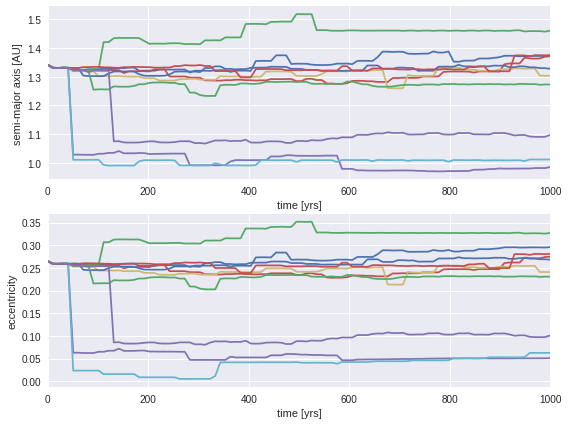

In [13]:

# coding: utf-8

# # Starman

# This notebook integrates the orbit of Elon Musk's Tesla and Starman. The orbital parameters are taken from Bill Gray's website: https://www.projectpluto.com/temp/j95.htm#elements.

# In[24]:


import rebound
import numpy as np


# We start by querying NASA Horizons for the Solar System planets around the time of the orbit injection. 

# In[42]:


sim = rebound.Simulation()
sim.add(["Sun","Mercury","Venus","Earth","Mars","Jupiter","Saturn","Uranus","Neptune"],date="2018-02-10 00:00")
sim.save("ss.bin")


# We stored the simulation to a binary file. This allows us to reload it quickly to play around with things without having to query NASA Horizons too often.
# 
# Next up, we add the tesla to the simulation.

# In[43]:


sim = rebound.Simulation.from_file("ss.bin")
sim.add(primary=sim.particles[0],
        M=3.68007 *np.pi/180.,
        a=1.34126487,
        omega = 177.28664 *np.pi/180.,
        Omega = 317.45885 *np.pi/180.,
        e = 0.2648281,
        inc = 1.09424 *np.pi/180.)


# Let's calculate the characteristic energy (should be about $12~{\rm km}^2/{\rm s}^2$).

# In[44]:


tesla = sim.particles[-1]
earth = sim.particles[3]
r=np.linalg.norm(np.array(tesla.xyz) - np.array(earth.xyz))
v=np.linalg.norm(np.array(tesla.vxyz) - np.array(earth.vxyz))
energy = 0.5*v*v-earth.m/r
c3 = 2.*energy*887.40652 # from units where G=1, length=1AU to km and s
print("c3 = %f (km^2/s^2)" % c3)


# That seems about right! So let's look at the orbit. It starts at Earth's orbit, crosses that of Mars and then enters the asteroid belt.

# In[45]:


rebound.OrbitPlot(sim,lim=1.8,slices=True,color=True);


# And then integrate it forward in time. Here, we use the hybrid integrator MERCURIUS. You can experiment with other integrators which might be faster, but since this is an eccentric orbit, you might see many close encounters, so you either need a non-symplectic integrator such as IAS15 or a hybrid integrator such as MERCURIUS.

# In[46]:


# integrate
sim.dt = sim.particles[1].P/10. # small fraction of Mercury's period
sim.integrator="whfast"  
N = 100
times = np.linspace(0.,2.*np.pi*1e5,N)
a = np.zeros(N)
e = np.zeros(N)
for i,t in enumerate(times):
    sim.integrate(t,exact_finish_time=0)
    orbit = sim.particles[-1].calculate_orbit(primary=sim.particles[0])
    a[i] = orbit.a
    e[i] = orbit.e


# Let's plot the orbital parameters!

# In[47]:


get_ipython().magic(u'matplotlib inline')
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(9,7))
ax = plt.subplot(211)
ax.set_xlim([0,np.max(times)/2./np.pi])
ax.set_xlabel("time [yrs]")
ax.set_ylabel("semi-major axis [AU]")
plt.plot(times/2./np.pi,a)
ax = plt.subplot(212)
ax.set_xlim([0,np.max(times)/2./np.pi])
ax.set_xlabel("time [yrs]")
ax.set_ylabel("eccentricity")
plt.plot(times/2./np.pi,e);


# To check the sensitivity of the integrations, let us perturb the initial orbit by a small factor equal to the confidence interval posted by Bill Gray. Instead of just integrating one particle at a time, we here add 10 test particles. We also switch to the high precision IAS15 integrator to get the most reliable result.

# In[48]:


sim = rebound.Simulation.from_file("ss.bin")
Ntesla = 10
for i in range(Ntesla):
    sim.add(primary=sim.particles[0],
        M=(3.68007+0.0013*np.random.normal()) *np.pi/180.,
        a=(1.34126487+0.000273*np.random.normal()),
        omega = (177.28664+0.00059*np.random.normal()) *np.pi/180.,
        Omega = (317.45885+0.0007*np.random.normal()) *np.pi/180.,
        e = (0.2648281+0.00015*np.random.normal()),
        inc = (1.09424+0.0007*np.random.normal()) *np.pi/180.)
sim.N_active = 9 # Sun + planets


# Let's integrate this...

# In[49]:


sim.dt = sim.particles[1].P/10. # small fraction of Mercury's period
sim.integrator="whfast"  
N = 100
times = np.linspace(0.,2.*np.pi*1e3,N)
a_log = np.zeros((N,Ntesla))
e_log = np.zeros((N,Ntesla))
for i,t in enumerate(times):
    sim.integrate(t,exact_finish_time=0)
    for j in range(Ntesla):
        orbit = sim.particles[9+j].calculate_orbit(primary=sim.particles[0])
        a_log[i][j] = orbit.a
        e_log[i][j] = orbit.e


# When plotting the semi-major axis and eccentricity of all orbits, note that their kicks are correlated. This is because they are all due to close encounters with the Earth. This fast divergence means that we cannot predict the trajectory for more than a hundred years without knowing the precise initial conditions and all the non-gravitational effects that might be acting on a car in space.

# In[53]:


get_ipython().magic(u'matplotlib inline')
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(9,7))
ax = plt.subplot(211)
ax.set_xlim([0,np.max(times)/2./np.pi])
ax.set_xlabel("time [yrs]")
ax.set_ylabel("semi-major axis [AU]")
for j in range(Ntesla):
    plt.plot(times/2./np.pi,a_log[:,j])
ax = plt.subplot(212)
ax.set_xlim([0,np.max(times)/2./np.pi])
ax.set_xlabel("time [yrs]")
ax.set_ylabel("eccentricity")
for j in range(Ntesla):
    plt.plot(times/2./np.pi,e_log[:,j])

